In [1]:
!nvidia-smi  --query-gpu=name,memory.total,memory.used --format=csv,noheader

NVIDIA GeForce RTX 3060 Ti, 8192 MiB, 1287 MiB


## Coded by B.Heddle, E. Porter and N. Wong

In [2]:
#Import necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

Label_encoder = LabelEncoder()

In [3]:
# Load the train data_trainset
data_train = pd.read_csv('fraudTest.csv')
pd.set_option('display.max_columns', None)

#Convert Gender
gender_conversion = {'F': 0, 'M': 1}
data_train['gender'] = data_train['gender'].map(gender_conversion)

data_train['name'] = data_train['first'] + " " + data_train['last']
data_train['address'] = data_train['street'] + ", " + data_train['city'] + ", " + data_train['state']

#Convert first name
data_train['first#'] = Label_encoder.fit_transform(data_train['first'])

#Convert last  name
data_train['last#'] = Label_encoder.fit_transform(data_train['last'])

#Convert first name + last name
data_train['name#'] = Label_encoder.fit_transform(data_train['name'])

#data_train['age'] = 2024 - pd.to_numeric(data_train['dob'].str[:4]) 

#Convert Job
data_train['job#'] = Label_encoder.fit_transform(data_train['job'])

data_train['merchant#'] = Label_encoder.fit_transform(data_train['merchant'])

data_train['category#'] = Label_encoder.fit_transform(data_train['category'])


data_train['street#'] = Label_encoder.fit_transform(data_train['street'])
data_train['city#'] = Label_encoder.fit_transform(data_train['city'])
data_train['state#'] = Label_encoder.fit_transform(data_train['state'])

data_train['address#'] = Label_encoder.fit_transform(data_train['address'])

data_train['trans_num'] = Label_encoder.fit_transform(data_train['trans_num'])

def calculate_age(dob_str):
    dob = datetime.strptime(dob_str, '%Y-%m-%d')
    today = datetime.today()
    age = today.year - dob.year - ((today.month, today.day) < (dob.month, dob.day))
    return age

# Apply the function to the 'dob' column to create a new 'age' column
data_train['age'] = data_train['dob'].apply(calculate_age)

# Function to calculate distance using Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers
    lat1_rad, lon1_rad = np.radians(lat1), np.radians(lon1)
    lat2_rad, lon2_rad = np.radians(lat2), np.radians(lon2)
    
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return R * c  # Distance in kilometers

# Calculate distance for each row
data_train['distance_km'] = haversine(data_train['lat'], data_train['long'], data_train['merch_lat'], data_train['merch_long'])


#data_train = data_train.drop(columns=['first', 'last', 'street', 'street', 'city', 'state', 'trans_date_trans_time', 'Unnamed: 0', 'dob'])
data_train = data_train.drop(columns=['trans_date_trans_time','Unnamed: 0', 'dob'])# 'Unnamed: 0'])



data_train.head()

,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,trans_num,unix_time,merch_lat,merch_long,is_fraud,name,address,first#,last#,name#,job#,merchant#,category#,street#,city#,state#,address#,age,distance_km
0,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,1,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,98699,1371816865,33.986391,-81.200714,0,Jeff Elliott,"351 Darlene Green, Columbia, SC",151,115,377,275,319,10,341,157,39,341,56,24.561462
1,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,0,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",108785,1371816873,39.450498,-109.960431,0,Joanne Williams,"3638 Marsh Union, Altonah, UT",163,457,428,392,591,10,354,16,43,354,34,104.925092
2,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,0,9333 Valentine Point,Bellmore,NY,11710,40.6729,-73.5365,34496,"Librarian, public",433979,1371816893,40.495810,-74.196111,0,Ashley Lopez,"9333 Valentine Point, Bellmore, NY",24,249,70,259,611,5,865,61,33,865,54,59.080078
3,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,1,32941 Krystal Mill Apt. 552,Titusville,FL,32780,28.5697,-80.8191,54767,Set designer,71993,1371816915,28.812398,-80.883061,0,Brian Williams,"32941 Krystal Mill Apt. 552, Titusville, FL",42,457,109,407,222,9,320,764,8,320,37,27.698567
4,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,1,5783 Evan Roads Apt. 465,Falmouth,MI,49632,44.2529,-85.0170,1126,Furniture designer,190585,1371816917,44.959148,-85.884734,0,Nathan Massey,"5783 Evan Roads Apt. 465, Falmouth, MI",247,261,678,196,292,13,548,247,21,548,69,104.335106


In [4]:
# Load the test dataset
data_test = pd.read_csv('fraudTest.csv')
pd.set_option('display.max_columns', None)

#Convert Gender
gender_conversion = {'F': 0, 'M': 1}
data_test['gender'] = data_test['gender'].map(gender_conversion)

data_test['name'] = data_test['first'] + " " + data_test['last']
data_test['address'] = data_test['street'] + ", " + data_test['city'] + ", " + data_test['state']

#Convert first name
data_test['first#'] = Label_encoder.fit_transform(data_test['first'])

#Convert last  name
data_test['last#'] = Label_encoder.fit_transform(data_test['last'])

#Convert first name + last name
data_test['name#'] = Label_encoder.fit_transform(data_test['name'])

#data_test['age'] = 2024 - pd.to_numeric(data_test['dob'].str[:4]) 

#Convert Job
data_test['job#'] = Label_encoder.fit_transform(data_test['job'])

data_test['merchant#'] = Label_encoder.fit_transform(data_test['merchant'])

data_test['category#'] = Label_encoder.fit_transform(data_test['category'])

data_test['street#'] = Label_encoder.fit_transform(data_test['street'])
data_test['city#'] = Label_encoder.fit_transform(data_test['city'])
data_test['state#'] = Label_encoder.fit_transform(data_test['state'])

data_test['address#'] = Label_encoder.fit_transform(data_test['address'])

data_test['trans_num'] = Label_encoder.fit_transform(data_test['trans_num'])

def calculate_age(dob_str):
    dob = datetime.strptime(dob_str, '%Y-%m-%d')
    today = datetime.today()
    age = today.year - dob.year - ((today.month, today.day) < (dob.month, dob.day))
    return age

# Apply the function to the 'dob' column to create a new 'age' column
data_test['age'] = data_test['dob'].apply(calculate_age)

# Function to calculate distance using Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers
    lat1_rad, lon1_rad = np.radians(lat1), np.radians(lon1)
    lat2_rad, lon2_rad = np.radians(lat2), np.radians(lon2)
    
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return R * c  # Distance in kilometers

# Calculate distance for each row
data_test['distance_km'] = haversine(data_test['lat'], data_test['long'], data_test['merch_lat'], data_test['merch_long'])

#data_test = data_test.drop(columns=['first', 'last', 'street', 'street', 'city', 'state', 'trans_date_trans_time', 'Unnamed: 0', 'dob'])
data_test = data_test.drop(columns=['trans_date_trans_time','Unnamed: 0', 'dob'])# 'Unnamed: 0'])

data_test.head()

,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,trans_num,unix_time,merch_lat,merch_long,is_fraud,name,address,first#,last#,name#,job#,merchant#,category#,street#,city#,state#,address#,age,distance_km
0,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,1,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,98699,1371816865,33.986391,-81.200714,0,Jeff Elliott,"351 Darlene Green, Columbia, SC",151,115,377,275,319,10,341,157,39,341,56,24.561462
1,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,0,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",108785,1371816873,39.450498,-109.960431,0,Joanne Williams,"3638 Marsh Union, Altonah, UT",163,457,428,392,591,10,354,16,43,354,34,104.925092
2,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,0,9333 Valentine Point,Bellmore,NY,11710,40.6729,-73.5365,34496,"Librarian, public",433979,1371816893,40.495810,-74.196111,0,Ashley Lopez,"9333 Valentine Point, Bellmore, NY",24,249,70,259,611,5,865,61,33,865,54,59.080078
3,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,1,32941 Krystal Mill Apt. 552,Titusville,FL,32780,28.5697,-80.8191,54767,Set designer,71993,1371816915,28.812398,-80.883061,0,Brian Williams,"32941 Krystal Mill Apt. 552, Titusville, FL",42,457,109,407,222,9,320,764,8,320,37,27.698567
4,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,1,5783 Evan Roads Apt. 465,Falmouth,MI,49632,44.2529,-85.0170,1126,Furniture designer,190585,1371816917,44.959148,-85.884734,0,Nathan Massey,"5783 Evan Roads Apt. 465, Falmouth, MI",247,261,678,196,292,13,548,247,21,548,69,104.335106


In [5]:
# Splitting training data into features and target
X_train = data_train.drop(columns=['is_fraud'], axis=1)
y_train = data_train['is_fraud']

# Splitting test data into features and target
X_test = data_test.drop(columns=['is_fraud'], axis=1)
y_test = data_test['is_fraud']

In [6]:
# Identify numerical and categorical columns
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

# Pipeline for processing numerical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Handle missing values with the median
    ('scaler', StandardScaler())                   # Standardize numerical data
])

# Pipeline for processing categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle missing values with mode
    ('onehot', OneHotEncoder(handle_unknown='ignore'))     # One-hot encode categorical data
])

# Combine numerical and categorical transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),  # Apply numeric transformations
        ('cat', categorical_transformer, categorical_features)  # Apply categorical transformations
    ]
)

## Depth = 1, Weak Learners = 100

In [7]:
# Create AdaBoost model -> depth = 1, weak learners = 100
estimator = DecisionTreeClassifier(max_depth=1)
model = AdaBoostClassifier(estimator=estimator, n_estimators=100, random_state=20201107)

# Full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Train the model
pipeline.fit(X_train, y_train)

# Predictions
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

C:\Users\Nick\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.99647663657352
AUC Score: 0.986170470737123

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.59      0.28      0.38      2145

    accuracy                           1.00    555719
   macro avg       0.79      0.64      0.69    555719
weighted avg       1.00      1.00      1.00    555719



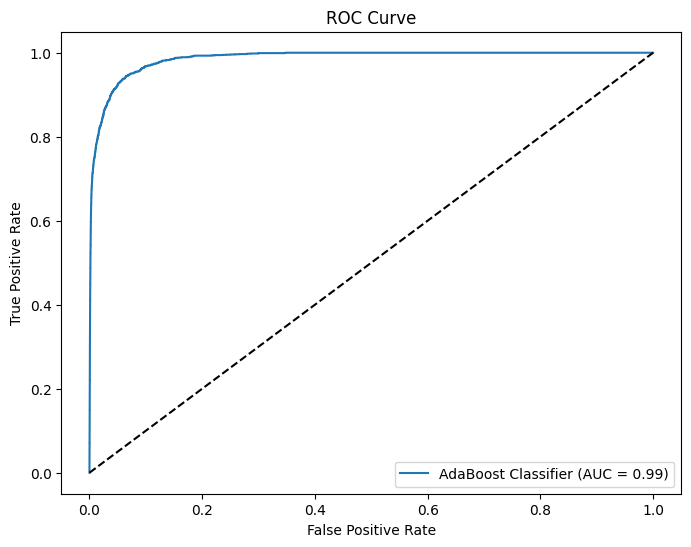

In [8]:
# Plotting ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='AdaBoost Classifier (AUC = {:.2f})'.format(roc_auc_score(y_test, y_proba)))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## Depth = 2, Weak Learners = 100

In [9]:
# Create AdaBoost model -> depth = 2, weak learners = 100
estimator = DecisionTreeClassifier(max_depth=2)
model = AdaBoostClassifier(estimator=estimator, n_estimators=100, random_state=20201107)

# Full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Train the model
pipeline.fit(X_train, y_train)

# Predictions
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

C:\Users\Nick\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.9984380595228883
AUC Score: 0.9990903817273915

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.85      0.72      0.78      2145

    accuracy                           1.00    555719
   macro avg       0.93      0.86      0.89    555719
weighted avg       1.00      1.00      1.00    555719



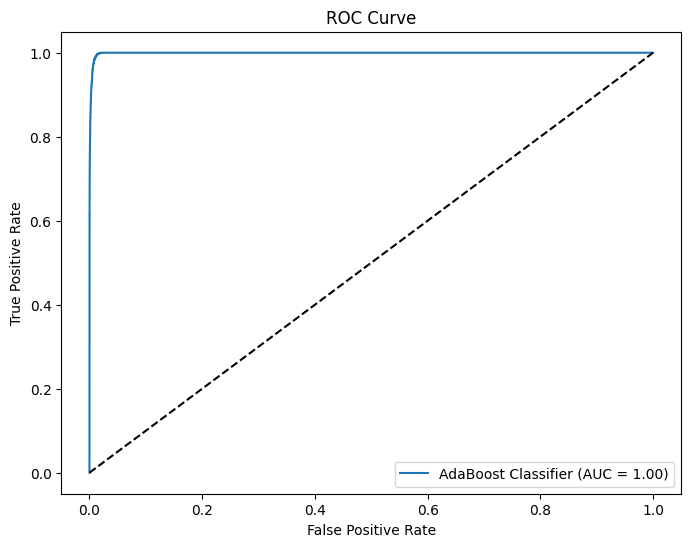

In [10]:
# Plotting ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='AdaBoost Classifier (AUC = {:.2f})'.format(roc_auc_score(y_test, y_proba)))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## Depth = 2, Weak Learners = 200

In [11]:
# Create AdaBoost model -> depth = 2, weak learners = 200
estimator = DecisionTreeClassifier(max_depth=2)
model = AdaBoostClassifier(estimator=estimator, n_estimators=200, random_state=20201107)

# Full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Train the model
pipeline.fit(X_train, y_train)

# Predictions
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

C:\Users\Nick\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.9991182594080822
AUC Score: 0.9997960946685056

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.93      0.83      0.88      2145

    accuracy                           1.00    555719
   macro avg       0.97      0.92      0.94    555719
weighted avg       1.00      1.00      1.00    555719



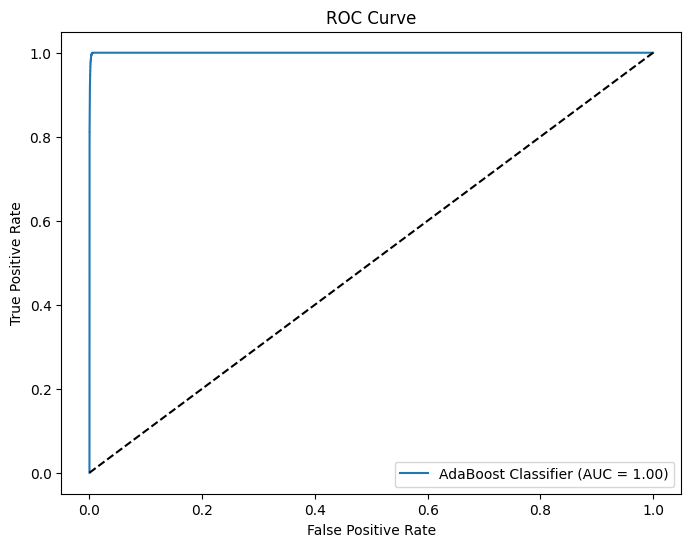

In [12]:
# Plotting ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='AdaBoost Classifier (AUC = {:.2f})'.format(roc_auc_score(y_test, y_proba)))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## Depth = 2, Weak Learners = 300

In [13]:
# Create AdaBoost model
estimator = DecisionTreeClassifier(max_depth=2)
model = AdaBoostClassifier(estimator=estimator, n_estimators=300, random_state=20201107)

# Full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Train the model
pipeline.fit(X_train, y_train)

# Predictions
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

C:\Users\Nick\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.9994907498214025
AUC Score: 0.9999515494242487

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.97      0.90      0.93      2145

    accuracy                           1.00    555719
   macro avg       0.98      0.95      0.97    555719
weighted avg       1.00      1.00      1.00    555719



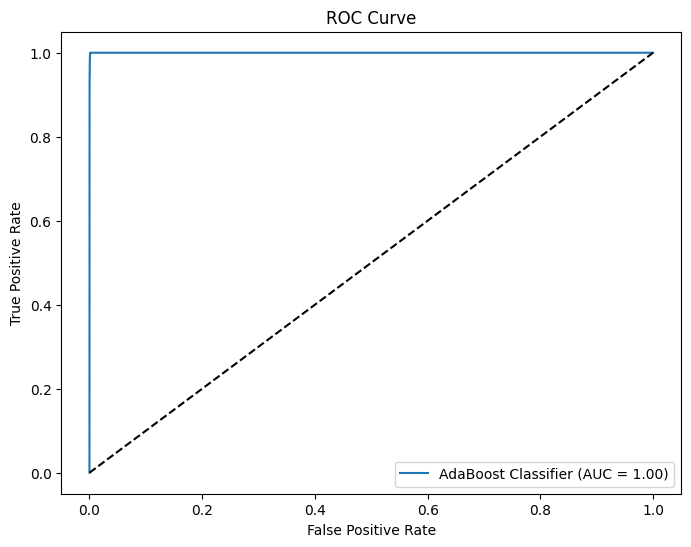

In [14]:
# Plotting ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='AdaBoost Classifier (AUC = {:.2f})'.format(roc_auc_score(y_test, y_proba)))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## Depth = 3, Weak Learners = 100

In [15]:
# Create AdaBoost model
estimator = DecisionTreeClassifier(max_depth=3)
model = AdaBoostClassifier(estimator=estimator, n_estimators=100, random_state=20201107)

# Full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Train the model
pipeline.fit(X_train, y_train)

# Predictions
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

C:\Users\Nick\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.9993629874091042
AUC Score: 0.9999111718390442

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.96      0.87      0.91      2145

    accuracy                           1.00    555719
   macro avg       0.98      0.94      0.96    555719
weighted avg       1.00      1.00      1.00    555719



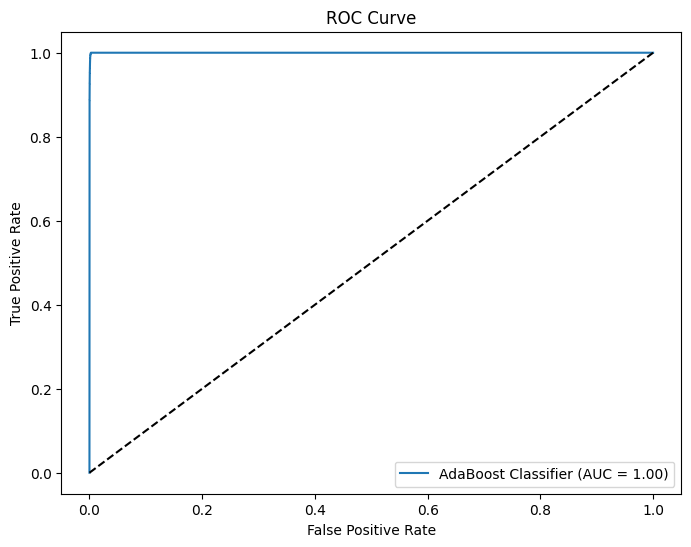

In [16]:
# Plotting ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='AdaBoost Classifier (AUC = {:.2f})'.format(roc_auc_score(y_test, y_proba)))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## Depth = 3, Weak Learners = 200

In [17]:
# Create AdaBoost model
estimator = DecisionTreeClassifier(max_depth=3)
model = AdaBoostClassifier(estimator=estimator, n_estimators=200, random_state=20201107)

# Full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Train the model
pipeline.fit(X_train, y_train)

# Predictions
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

C:\Users\Nick\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.9999874037058297
AUC Score: 0.9999999991578353

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       1.00      1.00      1.00      2145

    accuracy                           1.00    555719
   macro avg       1.00      1.00      1.00    555719
weighted avg       1.00      1.00      1.00    555719



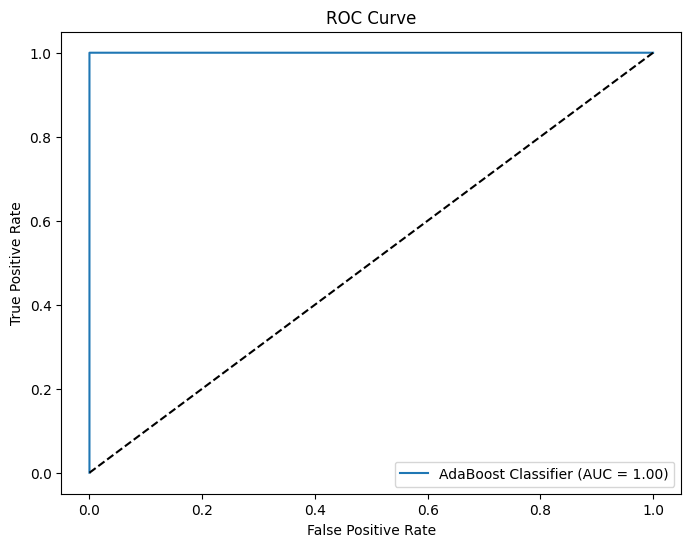

In [18]:
# Plotting ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='AdaBoost Classifier (AUC = {:.2f})'.format(roc_auc_score(y_test, y_proba)))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

        Feature  Total Importance
8     unix_time          0.158833
1           amt          0.095549
23     merchant          0.077834
24     category          0.047343
30          job          0.041527
26         last          0.039717
14         job#          0.032867
21          age          0.031809
25        first          0.030764
4           lat          0.028904
18        city#          0.027963
10   merch_long          0.025815
7     trans_num          0.025697
29        state          0.024735
6      city_pop          0.024729
12        last#          0.022665
22  distance_km          0.022658
31         name          0.021658
0        cc_num          0.021048
13        name#          0.019066
27       street          0.017700
32      address          0.017661
28         city          0.016864
9     merch_lat          0.016717
16    category#          0.016487
20     address#          0.015673
17      street#          0.015138
19       state#          0.014749
3           zi

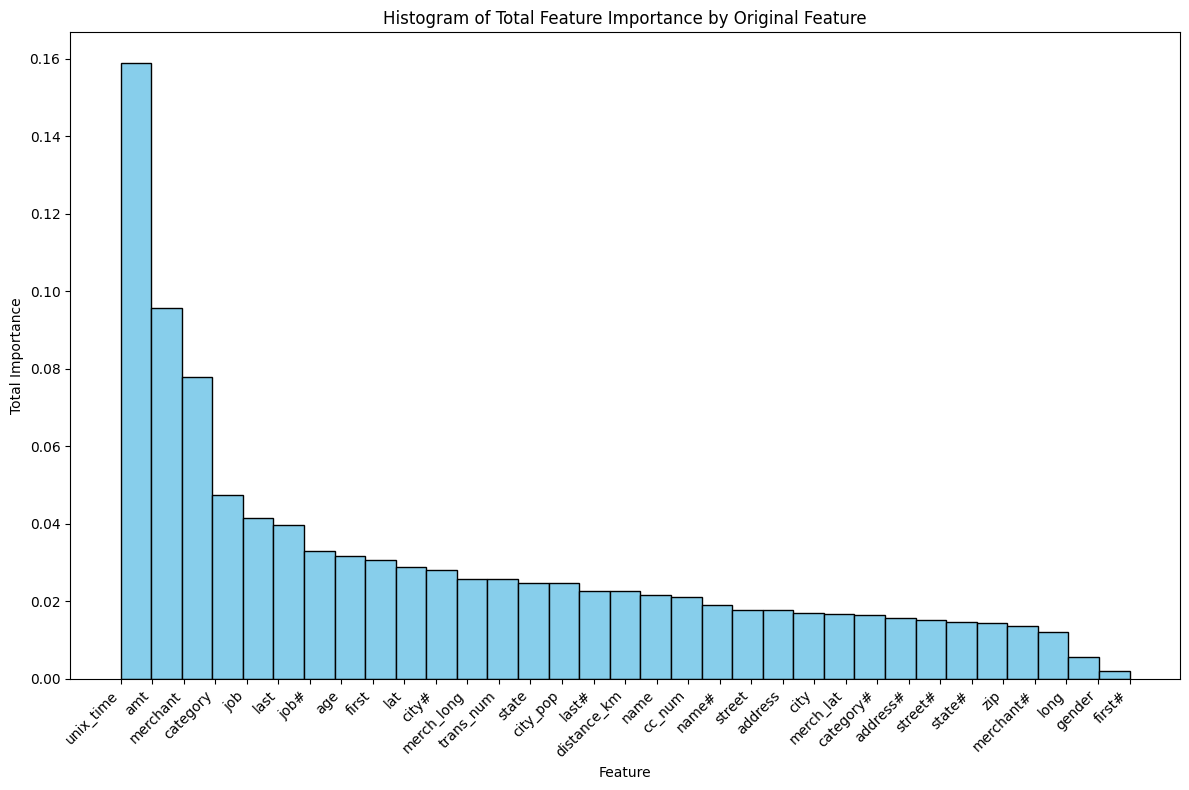

In [19]:
# Extract the model from the pipeline
adaboost_model = pipeline.named_steps['classifier']

# Get preprocessed feature names
onehot_categories = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
numeric_features_list = numeric_features.tolist()

# Combined feature names after preprocessing
all_feature_names = np.concatenate([numeric_features_list, onehot_categories])

# Feature importances from the AdaBoost model
feature_importances = adaboost_model.feature_importances_

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances
})

# Sum feature importances by original feature
# Initialize a dictionary to store summed importances
feature_importance_summary = {}

# Sum importances for numeric features directly
for feature in numeric_features_list:
    feature_importance_summary[feature] = feature_importance_df.loc[
        feature_importance_df['Feature'] == feature, 'Importance'].sum()

# Sum importances for categorical features by grouping one-hot encoded columns
for original_feature in categorical_features:
    # Identify one-hot encoded columns for this original feature
    related_columns = [col for col in onehot_categories if col.startswith(original_feature)]
    # Sum their importances
    total_importance = feature_importance_df.loc[
        feature_importance_df['Feature'].isin(related_columns), 'Importance'].sum()
    feature_importance_summary[original_feature] = total_importance

# Create a DataFrame from the summary
importance_summary_df = pd.DataFrame(
    list(feature_importance_summary.items()),
    columns=['Feature', 'Total Importance']
).sort_values(by='Total Importance', ascending=False)

# Display the summary
print(importance_summary_df)

# Plotting the total importance as a histogram
plt.figure(figsize=(12, 8))
plt.hist(importance_summary_df['Feature'], weights=importance_summary_df['Total Importance'], bins=len(importance_summary_df), color='skyblue', edgecolor='black')
plt.xlabel('Feature')
plt.ylabel('Total Importance')
plt.title('Histogram of Total Feature Importance by Original Feature')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

           Feature Type  Total Importance
0    Numerical Features          0.664196
1  Categorical Features          0.335804


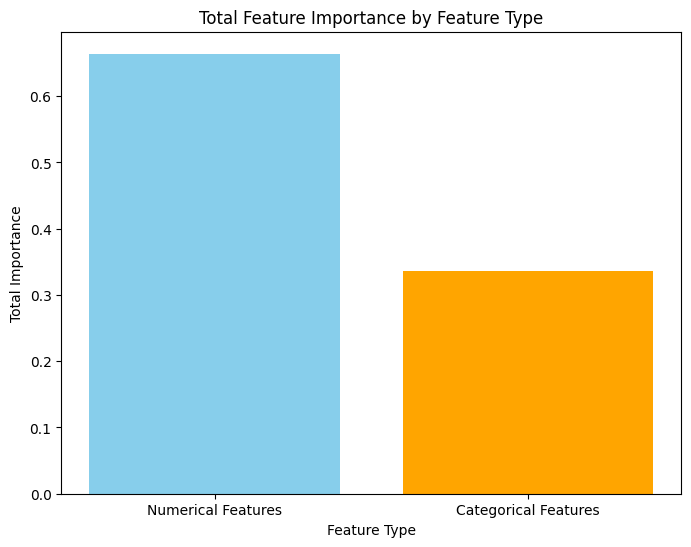

In [20]:

# Get preprocessed feature names
onehot_categories = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
numeric_features_list = numeric_features.tolist()

# Combined feature names after preprocessing
all_feature_names = np.concatenate([numeric_features_list, onehot_categories])

# Feature importances
feature_importances = adaboost_model.feature_importances_

# Create a DataFrame for analysis
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances
})

# Separate numerical and categorical features
numeric_importance_total = feature_importance_df[feature_importance_df['Feature'].isin(numeric_features_list)]['Importance'].sum()
categorical_importance_total = feature_importance_df[feature_importance_df['Feature'].isin(onehot_categories)]['Importance'].sum()

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'Feature Type': ['Numerical Features', 'Categorical Features'],
    'Total Importance': [numeric_importance_total, categorical_importance_total]
})

# Display the summary
print(summary_df)

# Plot the total importance by feature type
plt.figure(figsize=(8, 6))
plt.bar(summary_df['Feature Type'], summary_df['Total Importance'], color=['skyblue', 'orange'])
plt.xlabel('Feature Type')
plt.ylabel('Total Importance')
plt.title('Total Feature Importance by Feature Type')
plt.show()